텍스트 벡터화

1. TF-IDF: 주어진 말뭉치에서 단어의 상대적인 등장 횟수 기반 문서 백터화

In [1]:
import pandas as pd
import spacy
import umap
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
import os

# if '__file__' in globals():
#     import os, sys
#     sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
    
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

from ml_editor.data_processing import format_raw_df, get_split_by_author
from ml_editor.data_visualization import plot_embeddings

data_path = Path("./data/processed/writers/writers.csv")
df = pd.read_csv(data_path, index_col=0)
df = format_raw_df(df.copy())

train_author, test_author = get_split_by_author(df[df["is_question"]])

TF-IDF는 전체 말뭉치와 비교하여 문서에 있는 각 단어의 상대적인 빈도를 기반으로 임베딩을 만든다.

In [2]:
questions = train_author[train_author["is_question"]]
raw_text = questions["body_text"]

sent_labels = questions["AcceptedAnswerId"].notna()

sent_labels.value_counts()

False    4158
True     4003
Name: AcceptedAnswerId, dtype: int64

In [3]:
raw_text.shape

(8161,)

In [4]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_features=2**21)

bag_of_words = vectorizer.fit_transform(raw_text)
bag_of_words.shape

(8161, 38178)

텍스트를 벡터화    
이 과정을 임베딩이라고 부르거나 벡터를 임베딩이라 부르기도 한다.    
t-SNE, PCA, UMAP과 같은 차원 축소 기법을 이용하여 2차원에 투영할 수 있다.

In [5]:
umap_embedder = umap.UMAP()
umap_bow = umap_embedder.fit_transform(bag_of_words)

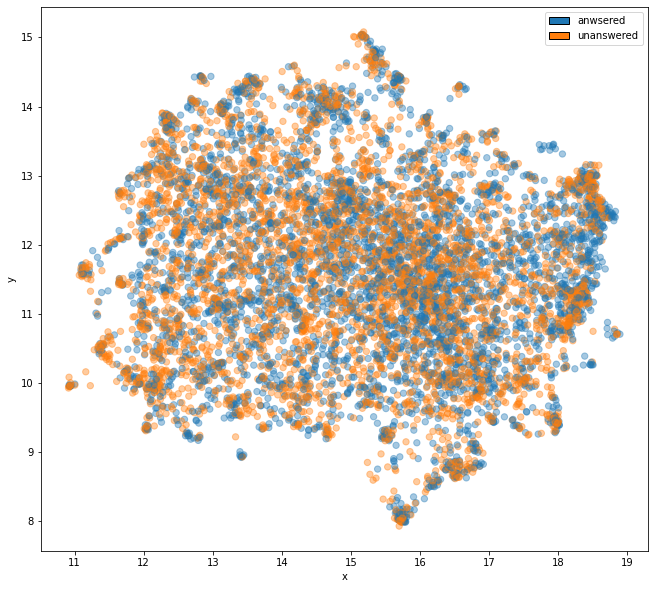

In [6]:
plot_embeddings(umap_bow, sent_labels)

2. 사전 훈련된 단어 임베딩
    - 매우 큰 말뭉치에서 훈련된 기존 단어 벡터를 로드

먼저 터미널에서
```
python -m spacy download en_core_web_lg
```

명령어를 통해 en_core_web_lg 다운로드

In [7]:
# 큰 모델을 로드하고 작업에 필요하지 않은 요소 제외
#  https://spacy.io/models/en#en_core_web_lg
nlp = spacy.load('en_core_web_lg', disable=["parser", "tagger", "ner", "textcat", "lemmatizer"])

In [8]:
# 각 질문에 대한 백터를 얻음
# 기본적으로 반환된 백터는 문장에 있는 모든 백터의 평균
spacy_emb = train_author[train_author["is_question"]]["body_text"].apply(lambda x: nlp(x).vector)
embeddings = np.vstack(spacy_emb)

In [9]:
umap_embedder = umap.UMAP()
umap_emb = umap_embedder.fit_transform(embeddings)

UMAP을 이용한 시각화

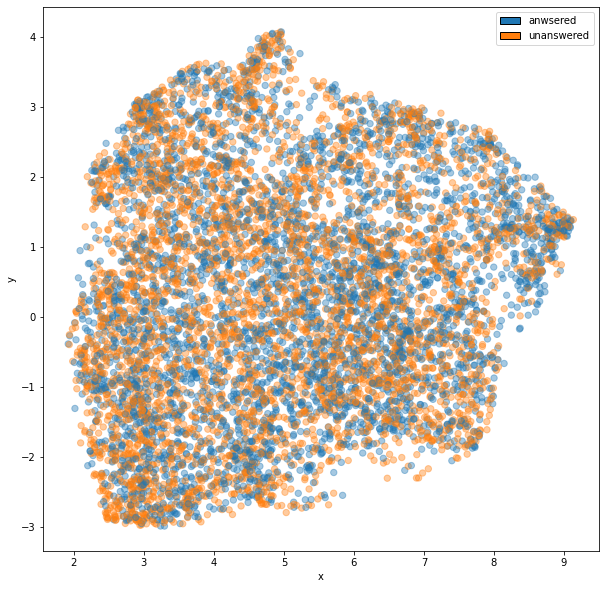

In [10]:
plot_embeddings(umap_emb, sent_labels)

import matplotlib.pyplot as plt
plt.savefig('./images/bmlpa_figures/ch04-9.png', dpi=300)

임베딩 방법이 다르기 때문에 위상이 다르지만 내재된 데이터는 동일하다.    
임베딩 방법이 다르면 데이터셋을 다르게 표현한다.     
데이터 벡터화 방식이 모델의 성능에 영향을 주는 경우가 있다.